# Crowie logs

Serge Droz <<serge.droz@first.org>>

This notebook does a quick analysis of [crowie honeypot](https://github.com/cowrie/cowrie) logs.

In [1]:
import pandas as pd
import json
import os
import folium
import geoip2.database
import colorsys
import math
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import datetime


## Read logs and clean data

The logs are not json files, they are files containing lines with json entries. We loop over the file to create an array of log entries. 

In [2]:
import zipfile

log = []
with zipfile.ZipFile('data/cowrie.json.2018-12-11.zip') as myzip:
    for l in  myzip.open('cowrie.json.2018-12-11'):
        log.append( json.loads( l ) )
df = pd.DataFrame( log )
df['timestamp'] = pd.to_datetime( df['timestamp'] ) 
df  

,eventid,shasum,url,timestamp,destfile,src_ip,outfile,session,message,sensor,...,compCS,encCS,data,height,width,key,fingerprint,type,name,value
0,cowrie.session.file_download,f919b9a88cd4aedf43145916d33f9ca10202735acec3b0...,http://198.98.62.237:80/bins/mirai.x86,2018-12-10 16:00:00.079025+00:00,-,198.98.62.237,var/lib/cowrie/downloads/f919b9a88cd4aedf43145...,73981a4e761a,Downloaded URL (http://198.98.62.237:80/bins/m...,mn-gemnet-cowrie-001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cowrie.session.file_download.failed,NaN,http://198.98.62.237:80/bins/mirai.x86,2018-12-10 16:00:00.081411+00:00,NaN,198.98.62.237,NaN,73981a4e761a,Attempt to download file(s) from URL (http://1...,mn-gemnet-cowrie-001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cowrie.command.input,NaN,NaN,2018-12-10 16:00:01.469172+00:00,NaN,198.98.62.237,NaN,73981a4e761a,CMD: ./dvrHelper telnet.x86; /bin/busybox IHCCE,mn-gemnet-cowrie-001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cowrie.command.failed,NaN,NaN,2018-12-10 16:00:01.471526+00:00,NaN,198.98.62.237,NaN,73981a4e761a,Command not found: ./dvrHelper telnet.x86,mn-gemnet-cowrie-001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,cowrie.command.input,NaN,NaN,2018-12-10 16:00:02.735938+00:00,NaN,198.98.62.237,NaN,73981a4e761a,CMD: rm -rf upnp; > dvrHelper; /bin/busybox ECCHI,mn-gemnet-cowrie-001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315849,cowrie.session.file_download,05f8ec35aaeda68a18c57374c71eb922c4900bcb89de5b...,/proc/.nippon,2018-12-11 15:59:54.177620+00:00,/proc/.nippon,198.98.62.237,var/lib/cowrie/downloads/05f8ec35aaeda68a18c57...,5ecd0c4ff5e3,Saved redir contents with SHA-256 05f8ec35aaed...,mn-gemnet-cowrie-001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315850,cowrie.session.file_download,31f96d1394f56bc2629123655194f1a50854caf1f9a087...,/proc/sys/fs/binfmt_misc/.nippon,2018-12-11 15:59:54.179913+00:00,/proc/sys/fs/binfmt_misc/.nippon,198.98.62.237,var/lib/cowrie/downloads/31f96d1394f56bc262912...,5ecd0c4ff5e3,Saved redir contents with SHA-256 31f96d1394f5...,mn-gemnet-cowrie-001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315851,cowrie.session.file_download,19a34e6b661946f1dbbfee814c3e1f81b9cefdfd9e7594...,/run/lock/.nippon,2018-12-11 15:59:54.182197+00:00,/run/lock/.nippon,198.98.62.237,var/lib/cowrie/downloads/19a34e6b661946f1dbbfe...,5ecd0c4ff5e3,Saved redir contents with SHA-256 19a34e6b6619...,mn-gemnet-cowrie-001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315852,cowrie.log.closed,e3904beb3c9c38771310ecf23b7ad42c2929e4271986c8...,NaN,2018-12-11 15:59:54.188279+00:00,NaN,198.98.62.237,NaN,5ecd0c4ff5e3,Closing TTY Log: var/lib/cowrie/tty/e3904beb3c...,mn-gemnet-cowrie-001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The timestamps are UTC, but contain timezone info. We remove this, so we can use normal datetime objects.

In [26]:
df['timestamp'] = df['timestamp'].dt.tz_convert(None)

Show the available columns

In [3]:
df.columns

Index(['eventid', 'shasum', 'url', 'timestamp', 'destfile', 'src_ip',
       'outfile', 'session', 'message', 'sensor', 'input', 'ttylog',
       'duration', 'size', 'username', 'password', 'arch', 'src_port',
       'dst_ip', 'protocol', 'dst_port', 'version', 'macCS', 'hasshAlgorithms',
       'kexAlgs', 'langCS', 'keyAlgs', 'hassh', 'compCS', 'encCS', 'data',
       'height', 'width', 'key', 'fingerprint', 'type', 'name', 'value'],
      dtype='object')

## Geographical distribution of the sources
We want to plot the the source locations and color depending on the number of occurences. 

In [4]:

cmap = matplotlib.cm.get_cmap('YlOrRd')

def get_color_( v ):
    (r, g, b) = [ int(255 * i) for i in colorsys.hsv_to_rgb(v , 1.0, 1.0) ]
    #print( r,g,b )
    return '#{:06X}'.format( 256 * ( 256 * r + g ) + b )  

def get_color( v ):
    '''Return a palette RGB value for an argumennt between 0 and 1.'''
    (r, g, b) = [ int(255 * i) for i in  cmap(1-v)[:-1] ]
    #print( r,g,b )
    return '#{:06X}'.format( 256 * ( 256 * r + g ) + b )  
#cmap(0.4)
#get_color( 0.4)

We use GeoIP and folium to create a nice map

In [5]:
reader = geoip2.database.Reader( os.path.join(os.path.expanduser('~'), 'Library/maxmind/GeoLite2-City_20190507/GeoLite2-City.mmdb') )
m = folium.Map(zoom_start=2, location=[0,0])
# 
values = list(zip(df['src_ip'].value_counts().index.tolist(), df['src_ip'].value_counts().values.tolist() ) )
m_value = values[0][1]

for i in values:
    try:
        response = reader.city( i[0] )
    except:
        continue
    c = get_color( math.log( i[1] ) / math.log( m_value) )
    pos = ( response.location.latitude , response.location.longitude )
    #folium.Marker( location=pos,icon=folium.Icon(color='darkpurple') ).add_to(m)
    folium.CircleMarker( pos , radius=2, color=c ).add_to(m)
m

## Get all download URLs

In [6]:
downloads = df[(~df['message'].isna())&(df['message'].str.contains('Downloaded URL'))][['shasum','url']]
downloads

,shasum,url
0,f919b9a88cd4aedf43145916d33f9ca10202735acec3b0...,http://198.98.62.237:80/bins/mirai.x86
119,f919b9a88cd4aedf43145916d33f9ca10202735acec3b0...,http://198.98.62.237:80/bins/mirai.x86
260,f919b9a88cd4aedf43145916d33f9ca10202735acec3b0...,http://198.98.62.237:80/bins/mirai.x86
471,a11f9333f6fc1cb6540d4e949de5ef462b86ebc292a499...,http://209.141.35.236:80/bins/x86
842,f919b9a88cd4aedf43145916d33f9ca10202735acec3b0...,http://198.98.62.237:80/bins/mirai.x86
...,...,...
315356,f919b9a88cd4aedf43145916d33f9ca10202735acec3b0...,http://198.98.62.237:80/bins/mirai.x86
315774,f919b9a88cd4aedf43145916d33f9ca10202735acec3b0...,http://198.98.62.237:80/bins/mirai.x86
315779,f919b9a88cd4aedf43145916d33f9ca10202735acec3b0...,http://198.98.62.237:80/bins/mirai.x86
315781,f919b9a88cd4aedf43145916d33f9ca10202735acec3b0...,http://198.98.62.237:80/bins/mirai.x86


## Samples

a (manual) check on Virustotal shows, that all but the last sample are mirai. The last one seem to be something different.

In [7]:
downloads['shasum'].value_counts()

f919b9a88cd4aedf43145916d33f9ca10202735acec3b052b842cfdbaf5ba27b    2143
a11f9333f6fc1cb6540d4e949de5ef462b86ebc292a499a7dc3dee5b37e4e377     159
d5e6a22b5291564377419877dbc6b309cd93d6007f506114fe779e94ddd22a79      35
783b9541ac8375ab6e0921a7b8451a5aa39218b0a0d66e291841d7620f9d29ac      18
9c061b40865bbcff3a9df1d9552ba7afc739fc79ef6a14f9f21ce7d6a0e513de       3
c65b2eff181f8a95e8a756d24f71d14bf81340c82ec788ec73cad467f186f9ea       2
42c3c05774f59e3d79589ec18ce7a1a39550c563e8d372d5bc679b802c9533f1       1
5796e576335cd4a64d8b5f02c9a769acbca01cad44686e6fb5c2facc4cd43c52       1
Name: shasum, dtype: int64

## Timeline

Plot the timeline per protocol. Note the kink in the ssh connections around 14:00

In [23]:
df[df['protocol'].isnull()][['eventid', 'src_ip', 'message','protocol']]

,eventid,src_ip,message,protocol
0,cowrie.session.file_download,198.98.62.237,Downloaded URL (http://198.98.62.237:80/bins/m...,NaN
1,cowrie.session.file_download.failed,198.98.62.237,Attempt to download file(s) from URL (http://1...,NaN
2,cowrie.command.input,198.98.62.237,CMD: ./dvrHelper telnet.x86; /bin/busybox IHCCE,NaN
3,cowrie.command.failed,198.98.62.237,Command not found: ./dvrHelper telnet.x86,NaN
4,cowrie.command.input,198.98.62.237,CMD: rm -rf upnp; > dvrHelper; /bin/busybox ECCHI,NaN
...,...,...,...,...
315849,cowrie.session.file_download,198.98.62.237,Saved redir contents with SHA-256 05f8ec35aaed...,NaN
315850,cowrie.session.file_download,198.98.62.237,Saved redir contents with SHA-256 31f96d1394f5...,NaN
315851,cowrie.session.file_download,198.98.62.237,Saved redir contents with SHA-256 19a34e6b6619...,NaN
315852,cowrie.log.closed,198.98.62.237,Closing TTY Log: var/lib/cowrie/tty/e3904beb3c...,NaN


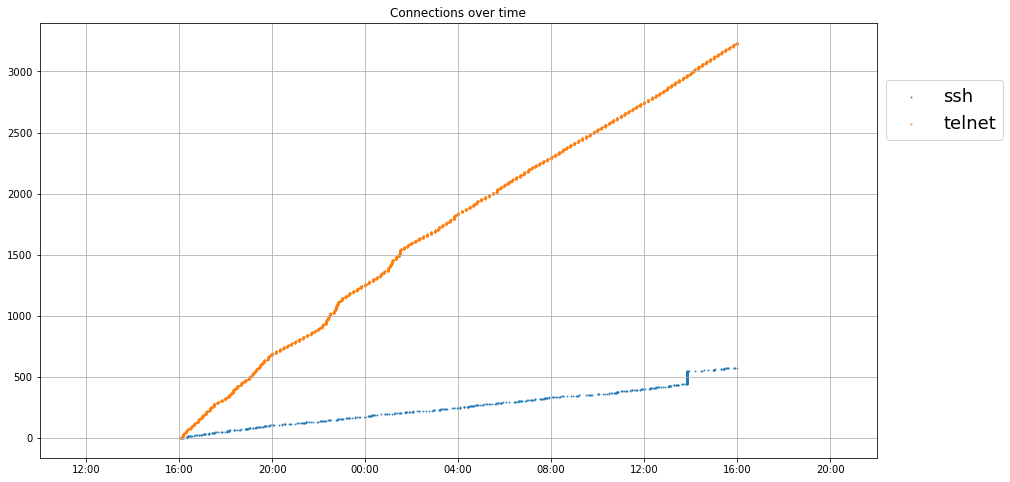

In [24]:

def plot_timeline( df ):
        
    end = df['timestamp'].max() + datetime.timedelta(hours=6)
    #end = datetime.datetime(2019,5,10,6,0,0)
    start = df['timestamp'].min()-datetime.timedelta(hours=6)
    fig, ax = plt.subplots(figsize=(15, 8))
    #fig, ax = plt.subplots(figsize=(24,85))
    c = 0
    
    #for i in df[~df['signature_name'].str.contains('MS Remote Desktop')]['signature_name'].unique():
    for i in ['ssh', 'telnet']:
        ys = pd.Series( range(len(df[df['protocol'] == i])), dtype='float64'  )
        xs = pd.Series( df[df['protocol'] == i]['timestamp'] )
        ax.scatter(xs, ys, s=1, label=i,alpha = 0.75)
    ax.set_xlim( start, end)
    ax.grid(True)
    ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.80), fontsize=18 )
    ax.set_title('Connections over time')
plot_timeline( df )

In [27]:
a = datetime.datetime( 2018,12,11, 13,50,0 )
b = a + datetime.timedelta(minutes=20)
df[(df['timestamp']>a) & (df['timestamp']<b)]

,eventid,shasum,url,timestamp,destfile,src_ip,outfile,session,message,sensor,...,compCS,encCS,data,height,width,key,fingerprint,type,name,value
286670,cowrie.command.input,NaN,NaN,2018-12-11 13:50:00.032409,NaN,198.98.62.237,NaN,805b1a55c6dd,CMD: /bin/busybox wget; /bin/busybox tftp; /bi...,mn-gemnet-cowrie-001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286671,cowrie.command.success,NaN,NaN,2018-12-11 13:50:00.034774,NaN,198.98.62.237,NaN,805b1a55c6dd,Command found: wget,mn-gemnet-cowrie-001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286672,cowrie.command.success,NaN,NaN,2018-12-11 13:50:00.036980,NaN,198.98.62.237,NaN,805b1a55c6dd,Command found: tftp,mn-gemnet-cowrie-001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286673,cowrie.session.connect,NaN,NaN,2018-12-11 13:50:00.141104,NaN,118.194.132.112,NaN,5851c85d134c,New connection: 118.194.132.112:53818 (180.149...,mn-gemnet-cowrie-001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286674,cowrie.command.input,NaN,NaN,2018-12-11 13:50:00.195239,NaN,198.98.62.237,NaN,5da4e8ddc07a,CMD: rm /.t; rm /.sh; rm /.human,mn-gemnet-cowrie-001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291334,cowrie.command.input,NaN,NaN,2018-12-11 14:09:59.817504,NaN,198.98.62.237,NaN,cc08eb32fa63,CMD: rm /dev/.t; rm /dev/.sh; rm /dev/.human,mn-gemnet-cowrie-001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291335,cowrie.command.input,NaN,NaN,2018-12-11 14:09:59.822318,NaN,198.98.62.237,NaN,cc08eb32fa63,CMD: cd /,mn-gemnet-cowrie-001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291336,cowrie.command.input,NaN,NaN,2018-12-11 14:09:59.830182,NaN,198.98.62.237,NaN,cc08eb32fa63,CMD: /bin/busybox cp /bin/echo dvrHelper; >dvr...,mn-gemnet-cowrie-001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291337,cowrie.command.success,NaN,NaN,2018-12-11 14:09:59.832861,NaN,198.98.62.237,NaN,cc08eb32fa63,Command found: cp /bin/echo dvrHelper,mn-gemnet-cowrie-001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This seems to be the IP 198.98.62.237. This is by far the most prevalent IP. 

In [28]:
df['src_ip'].value_counts()

198.98.62.237      272944
205.185.123.210     23820
51.15.252.59         4056
51.15.228.38         2946
104.248.43.220       1717
                    ...  
212.230.136.135         2
49.49.69.179            2
5.188.10.156            2
76.25.2.96              2
122.2.223.242           2
Name: src_ip, Length: 519, dtype: int64

## Input

Show all the stuff that happened

In [ ]:
df['input'].unique()

array([nan, './dvrHelper telnet.x86; /bin/busybox IHCCE',
       './dvrHelper telnet.x86',
       'rm -rf upnp; > dvrHelper; /bin/busybox ECCHI', 'enable', 'shell',
       'sh', '/bin/busybox ECCHI', '/bin/busybox ps; /bin/busybox ECCHI',
       'ps', '/bin/busybox cat /proc/mounts; /bin/busybox ECCHI',
       'cat /proc/mounts',
       "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69' > /.nippon; /bin/busybox cat /.nippon; /bin/busybox rm /.nippon",
       'echo -e \\x6b\\x61\\x6d\\x69', 'cat /.nippon', 'rm /.nippon',
       "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/sys' > /sys/.nippon; /bin/busybox cat /sys/.nippon; /bin/busybox rm /sys/.nippon",
       'echo -e \\x6b\\x61\\x6d\\x69/sys', 'cat /sys/.nippon',
       'rm /sys/.nippon',
       "/bin/busybox echo -e '\\x6b\\x61\\x6d\\x69/proc' > /proc/.nippon; /bin/busybox cat /proc/.nippon; /bin/busybox rm /proc/.nippon",
       'echo -e \\x6b\\x61\\x6d\\x69/proc', 'cat /proc/.nippon',
       'rm /proc/.nippon',
       "/bin/busybox echo -

# New Section